# Midterm Project


You will demonstrate your ability to solve a classification task.

The notebook that you submit *should follow the Recipe for Machine Learning* in addition to answering the questions.

# Objectives

For the student to demonstrate mastery on solving a classification problem and presenting
the entire Recipe for Machine Learning process in a notebook.

There will be little explicit direction for this task.

It is meant to be analagous to a pre-interview task that a potential employer might assign
to verify your skill

# The problem

You are to predict whether a company will go bankrupt in the following year, based on financial attributes of the company.
- Each row of data corresponds to a single company
- There are 64 attributes, described in the section below
- The last column (`Bankrupt`) is 1 if the company subsequently went bankrupt; 0 if it did not go bankrupt
- The first column is a Company Identifier

## Preparation
1. import packages
2. define functions
> 1 run different models and return the accuracy (in sample and out of sample)  
> 2 use Random Forest to calculate the importance of each features, and return photo  
> 3 split data, run models and return accuracy and importance

In [374]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split

# run different models
def Run_Model(model_name, x_train, y_train, x_test, y_test, w0, w1):  # model_name is a string, w0 w1 are the weight of 0 and 1 in Bankrupt to deal with umblanced model
    if model_name == 'NB':  # judge which model should be used
        model = GaussianNB()  
        y_score = 0  # NB can not calculate y_score
    elif model_name == 'LR':
        model = LogisticRegression(penalty='l2',C=1,class_weight={1:w1,0:w0}) 
        y_score = 1  # LR could calculate y_score
        
    model.fit(x_train, y_train)  
    y_pred1 = model.predict(x_train)  # in sample prediction
    y_pred2 = model.predict(x_test)  # out of sample prediction

    accuracy1 = accuracy_score(y_train, y_pred1)  # in sample accuracy
    accuracy2 = accuracy_score(y_test, y_pred2)  # out of sample accuracy
    
    if y_score == 1:
        y_score = model.fit(x_train, y_train).decision_function(x_test)
    
    scores = cross_val_score(model, x_train, y_train, cv=5)  # cross volidation
    cross_val_avg = scores.mean()

    return accuracy1, accuracy2, scores, y_pred1, y_pred2, y_score


# print the importance of features
def Pick_Feature(data): 
    # drop nan, in case
    data = data.replace('?',np.nan)
    data = data.dropna()
    data = pd.DataFrame(data,dtype=np.float)
    # split data
    data = shuffle(data, random_state = 30).copy()
    x, y = data.iloc[:,:].copy(), data['Bankrupt']
    del x['Bankrupt'], x['Id']
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=30)
    # train random forest
    feat_labels = x_train.columns[:]
    forest = RandomForestClassifier(n_estimators=1000,n_jobs=-1,random_state=0,class_weight={1:1,0:0.5})
    forest.fit(x_train,y_train)
    # print importance
    importances = forest.feature_importances_
    indices=np.argsort(importances)[::-1]
    '''
    for f in range(x_train.shape[1]):
        # calculate the average impurity purity of 1000 decision trees to evaluate the feature
        print ("%2d) %-*s %f" % (f+1,30,feat_labels[f],importances[indices[f]]) )
    '''
    # print photo
    f, ax = plt.subplots(figsize=(13, 6))
    plt.title('Feature Importance-RandomForest')
    plt.bar(range(x_train.shape[1]),importances[indices],color='lightblue',align='center')
    plt.xticks(range(x_train.shape[1]),feat_labels,rotation=90)
    plt.xlim([-1,x_train.shape[1]])
    plt.tight_layout()
    plt.show()
    
    
# combine Run_Model and Pick_Feature
def Run_Pick(data, w0, w1):
    data = data.dropna()
    data = shuffle(data, random_state = 30).copy()

    # split train data into training and testing
    x, y = data.iloc[:,:].copy(), data['Bankrupt']
    del x['Bankrupt'], x['Id']
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=10)
    print("train data has {a} sample, test data has {b} sample".format(a = len(x_train), b = len(x_test)))

    model = "Naive Byes"
    accuracy1, accuracy2, scores,y_pred1, y_pred2, y_score = Run_Model('NB', x_train, y_train, x_test, y_test, w0, w1)
    print("{m:s}: CV score = {sc:3.2f}, in sample Accuracy = {a1:.2%}, out of sample Accuracy = {a2:.2%}".format(\
                    m=model, sc=scores.mean(), a1=accuracy1, a2=accuracy2))

    model = "Logistic"
    accuracy1, accuracy2, scores,y_pred1, y_pred2, y_score = Run_Model('LR', x_train, y_train, x_test, y_test, w0, w1)
    model_fpr, model_tpr, _ = roc_curve(y_test,y_score)
    roc = roc_auc_score(y_test, y_score)
    print("{m:s}: CV score = {sc:3.2f}, in sample Accuracy = {a1:.2%}, out of sample Accuracy = {a2:.2%}, roc = {r:.2%}".format(\
                    m=model, sc=scores.mean(), a1=accuracy1, a2=accuracy2, r = roc))

    plt.figure(figsize = (6, 5))
    plt.rcParams['font.size'] = 16
    # Plot both curves
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves of Logistic Regression 1')
    plt.show()

    Pick_Feature(data)

## Simply clean data and try basic models
- Simply look at the data and clean it
> 1. There are many duplication in data set, so delete the deplicate one.
> 2. Rename the columns name to make it easier to be understand.
> 3. There are many '?' and '0' in data, we just delete '?' and leave '0' here
- Try Naive Byes and Logistic Regression model, to see the result.  
(basically, I am deleting data in rows here.)

Originally there are 3107 samples, 410 is bankrupt, 2697 is not
train data has 1075 sample, test data has 462 sample
Naive Byes 1: CV score = 0.18, in sample Accuracy = 17.21%, out of sample Accuracy = 17.97%
Logistic 1: CV score = 0.93, in sample Accuracy = 94.23%, out of sample Accuracy = 91.13%, roc = 64.71%


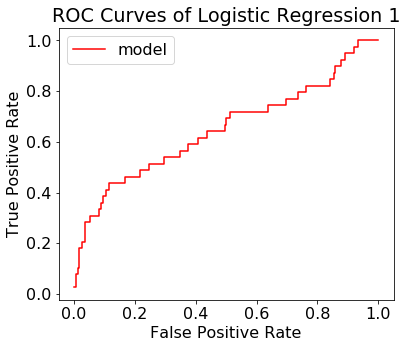

In [373]:
DATA_PATH = "./data/midterm_project"
df = pd.read_csv( os.path.join(DATA_PATH, "bankruptcy_data.csv") )
# delete duplications
df = df.drop_duplicates()
# rename columns
df.columns = ['Id','NP/TA','TL/TA','WC/TA','CA/SL','C+SS+R-SL/OE-D_y','RE/TA','EBIT/TA','BVE/TL','S/TA','E/TA',
    'GP+E+F/TA','GP/SL','GP+D/S','GP+I/TA','TL/GP+D_y','GP+D/TL','TA/TL','GP/TA','GP/S','I/S_y',
    'S_grows','PO/TA','NP/S','GP3/TA','E-S/TA','NP+D/TL','PO/FE','WC/FA','lgTA','TL-C/S',
    'GP+I/S','CL/CS_y','OE/SL','OE/TL','P/TA','TS/TA','CA-I/LL','CC/TA','P/S','CA-I-R/SL',
    'TL/PO+D_d_m','PO/S','RR+I_d','R/S_y','NP/I','CA-I/SL','I/CS_y','EBITDA/TA','EBIT/S','CA/TL',
    'SL/TA','SL/CP_y','E/FA','CC/FA','WC','S-CS/S','CA-I-SL/S-GP-D','TC/TA','LL/E','S/I',
    'S/R','SL/S_y','S/SL','S/FA','Bankrupt']

print('Originally there are {a} samples, {b} is bankrupt, {c} is not'.format(a = len(df), \
                                             b = len(df.loc[df['Bankrupt'] == 1]) , c = len(df.loc[df['Bankrupt'] == 0])))

data = df.replace('?',np.nan)
data = data.dropna()
data = pd.DataFrame(data,dtype=np.float)

# split train data into training and testing
x, y = data.iloc[:,:].copy(), data['Bankrupt']
del x['Bankrupt'], x['Id']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=10)
print("train data has {a} sample, test data has {b} sample".format(a = len(x_train), b = len(x_test)))

model = "Naive Byes"
accuracy1, accuracy2, scores,y_pred1, y_pred2, y_score = Run_Model('NB', x_train, y_train, x_test, y_test, 1, 1)
print("{m:s}: CV score = {sc:3.2f}, in sample Accuracy = {a1:.2%}, out of sample Accuracy = {a2:.2%}".format(\
                m=model, sc=scores.mean(), a1=accuracy1, a2=accuracy2))

model = "Logistic"
accuracy1, accuracy2, scores,y_pred1, y_pred2, y_score = Run_Model('LR', x_train, y_train, x_test, y_test, 1, 1)
model_fpr, model_tpr, _ = roc_curve(y_test,y_score)
roc = roc_auc_score(y_test, y_score)
print("{m:s}: CV score = {sc:3.2f}, in sample Accuracy = {a1:.2%}, out of sample Accuracy = {a2:.2%}, roc = {r:.2%}".format(\
                m=model, sc=scores.mean(), a1=accuracy1, a2=accuracy2, r = roc))
plt.figure(figsize = (6, 5))
plt.rcParams['font.size'] = 16
# Plot both curves
plt.plot(model_fpr, model_tpr, 'r', label = 'model')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves of Logistic Regression 1')
plt.show()

### Comment:
1. It is very strange to see that Naive Bayes present badly, but Logistic Regression is extremely great. It might cause by I deleting a half of the sample, since there are too many missing value.
2. The AUC ROC result is not good. These samples are unbalanced, too many bankrupt here, so **ROC is actually more reasonable than accuracy.**
3. **Next Step: delete the columns, which have missing value, and try the same model.**  
(we are deleting in columns here.)

train data has 2174 sample, test data has 933 sample
Naive Byes 2: CV score = 0.71, in sample Accuracy = 85.88%, out of sample Accuracy = 88.00%
Logistic 2: CV score = 0.86, in sample Accuracy = 86.75%, out of sample Accuracy = 87.35%, roc = 68.98%


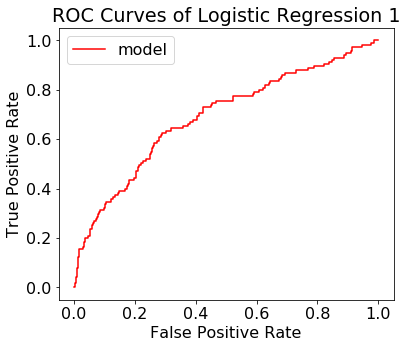

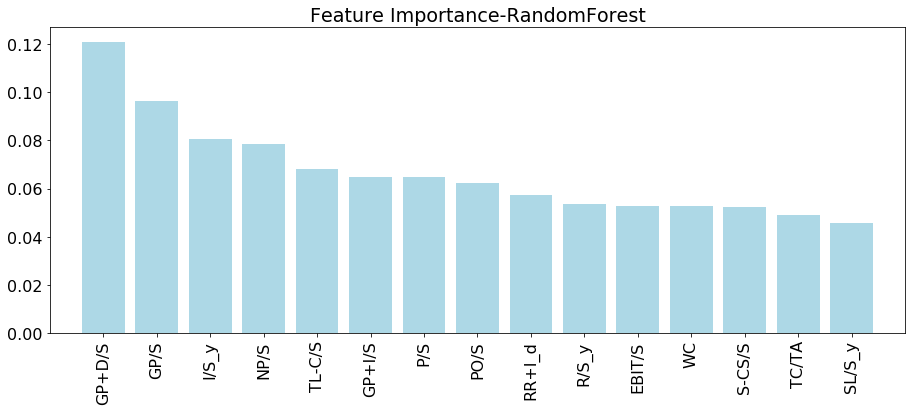

In [368]:
# count how many '?' in each colmun.
tem = pd.DataFrame((df == '?').sum().sort_values(ascending=False),columns=['not a ?'])
# pick up the columns with no '?'
data = df.loc[:,list(tem.loc[tem['not a ?'] == 0].index)]
data = data.dropna()
data = pd.DataFrame(data,dtype=np.float)
# run the same model as above, and print the importance of features (details are in function definition)

Run_Pick(data, 1, 1)

### Comment
1. The result is much better. Since the NB and LR models have the simlar result and the roc improves a little. **So deleting in columns is reasonable, bacause we will not have bais in choosing samples. And I choose this model as a base model.**
2. From the importance photo we can see all features are important, and it may be because there is few features.
3. **Next Step: Process the missing values, try to add more features in the model.**

## Missing Value & Feature Engineering
- For convenience, I didn't split the train set into two parts. I will do that after exporing the features.
- Here, I am counting how many '?' in each feature and in these missings how many samples bankrupt.

In [383]:
data = df.copy()
print('feature  amount  percent of Bankruptcy in missing \n')
question_mark_total = (data == '?').sum().sort_values(ascending=False)
question_mark_percent = ((data == '?').sum()/data.count()).sort_values(ascending=False)
question_mark_data = pd.concat([question_mark_total, question_mark_percent], axis=1, keys=['? Total', '? Percent'], sort = False)
question_mark_data = question_mark_data.loc[question_mark_data['? Total'] > 0]
for i in question_mark_data.index:
    print(i,':  ',len(data.loc[data[i]  == '?']),',  ',data.loc[data[i]  == '?'].Bankrupt.sum()/len(data.loc[data[i]  == '?']))

feature  amount  percent of Bankruptcy in missing 

CA-I/LL :   1350 ,   0.15555555555555556
PO/FE :   253 ,   0.48616600790513836
NP/I :   156 ,   0.24358974358974358
S/I :   156 ,   0.24358974358974358
S_grows :   101 ,   0.9801980198019802
GP3/TA :   61 ,   0.01639344262295082
S/FA :   56 ,   0.3392857142857143
CC/FA :   56 ,   0.3392857142857143
WC/FA :   56 ,   0.3392857142857143
E/FA :   56 ,   0.3392857142857143
TL/PO+D_d_m :   42 ,   0.0
CL/CS_y :   20 ,   0.05
SL/CP_y :   16 ,   0.0
I/CS_y :   16 ,   0.0
OE/SL :   14 ,   0.21428571428571427
GP/SL :   14 ,   0.21428571428571427
CA-I/SL :   14 ,   0.21428571428571427
CA-I-R/SL :   14 ,   0.21428571428571427
S/SL :   14 ,   0.21428571428571427
CA/SL :   14 ,   0.21428571428571427
GP+D/TL :   13 ,   0.23076923076923078
CA/TL :   13 ,   0.23076923076923078
TA/TL :   13 ,   0.23076923076923078
BVE/TL :   13 ,   0.23076923076923078
NP+D/TL :   13 ,   0.23076923076923078
OE/TL :   13 ,   0.23076923076923078
S/R :   9 ,   0.44444444444

### Comment:
- Serveral things interesting:
> 1. I notice '?' frequently appears in division feature. So I assume '?' means infinite, because they divided by an 0.
> 2. CA-I/LL has 1350 missing, becasue a half samples do not have long-term liability, and there is another features 'LL/E' can represent it, because if a company with 0 long-term liability, 'long-term liability / equity' will be 0
> 3. There seem to have 3 sample doesn't have lgTA (Total Asset). dealing with it, we can have many new features added in, becasue many features divided by TA, and become '?' because these three samples.
> 4. Missing in 'S_grows' and 'PO/FE' have high probability to bankrupt.
- Next Step: process the missing in 'lgTA', 'S_grows' and 'PO/FE'

In [378]:
df.loc[df['lgTA'] == '?']

,Id,NP/TA,TL/TA,WC/TA,CA/SL,C+SS+R-SL/OE-D_y,RE/TA,EBIT/TA,BVE/TL,S/TA,E/TA,GP+E+F/TA,GP/SL,GP+D/S,GP+I/TA,TL/GP+D_y,GP+D/TL,TA/TL,GP/TA,GP/S,I/S_y,S_grows,PO/TA,NP/S,GP3/TA,E-S/TA,NP+D/TL,PO/FE,WC/FA,lgTA,TL-C/S,GP+I/S,CL/CS_y,OE/SL,OE/TL,P/TA,TS/TA,CA-I/LL,CC/TA,P/S,CA-I-R/SL,TL/PO+D_d_m,PO/S,RR+I_d,R/S_y,NP/I,CA-I/SL,I/CS_y,EBITDA/TA,EBIT/S,CA/TL,SL/TA,SL/CP_y,E/FA,CC/FA,WC,S-CS/S,CA-I-SL/S-GP-D,TC/TA,LL/E,S/I,S/R,SL/S_y,S/SL,S/FA,Bankrupt
899,1783,?,?,?,?,3825.1,?,?,?,0.83894,?,?,?,0.000000,?,?,?,?,?,0.000000,784.560,1.2822,?,0.0,?,?,?,8.2051,11.588,?,-6.0095,0.000000,0,?,?,?,?,?,?,0.978030,?,0,0.978030,3213.800,2429.3,0,?,658.2,?,0.978030,?,?,0,1.1952,1.1952,12860.0,-0.191980,0,1.19200,0,0.46523,0.15025,0.0,?,3.7643,0
1459,4884,?,?,?,?,0,?,?,?,?,?,?,?,-0.006421,?,0,?,?,?,-0.022014,0.000,1.0759,?,0.0,?,?,?,0.1175,?,?,0.0000,-0.007945,0,?,?,?,?,?,?,0.004731,?,0,0.003011,0.000,0.0,?,?,0,?,-0.012582,?,?,0,?,?,0.0,0.004731,?,1.02200,?,?,?,0.0,?,?,0
4046,5880,?,?,?,0,-1076400,?,?,0,7.2533,?,?,0,0.114890,?,218270,0.001672,0,?,0.000000,75.483,?,?,0.0,?,?,0.001672,?,?,?,68.7040,0.000000,181890,0.002007,0,?,?,?,?,0.000000,-0.00301,19.66,0.000000,75.483,0.0,0,-0.00301,547.5,?,-0.114890,0,?,498.33,?,?,-2990.0,0.439610,?,0.13787,?,4.8356,?,25077.0,0.014555,?,1


### Comment
1. We can see these 3 samples are almost missing all the features so they are useless, and delete them directly. And if this situation happen in test set, just return pridiction Bankrupt=0 (Maximum likelihood method). Then we will have many new features add in the model.
2. The companies have no sales growing rate means they do not have last year's sale, so they are new companies, and new companies do have higher probability to bankrupt. So set a feature 'New' means it is a new company and 'S_grows' is '?', and then use 1 to fill the missing in 'S_grows', means new companies have no grow in sales.
3. Set a new feature 'FE_is0' means financial expenses is 0 and 'PO/FE' is missing. Then delete 'PO/FE'. We don't need to worry losing information, because we have 'Profit in Operating/Total Asset' feature, so we have information of Profit in Operating.
4. Add these new features and test the model.

train data has 2172 sample, test data has 932 sample
Naive Byes: CV score = 0.73, in sample Accuracy = 86.14%, out of sample Accuracy = 88.84%
Logistic: CV score = 0.87, in sample Accuracy = 86.97%, out of sample Accuracy = 88.95%, roc = 81.46%


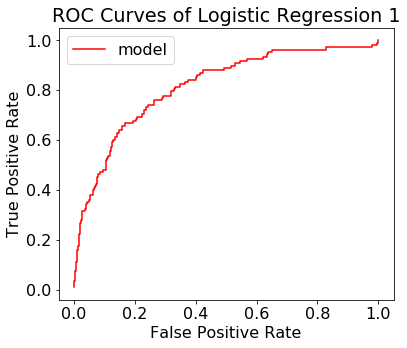

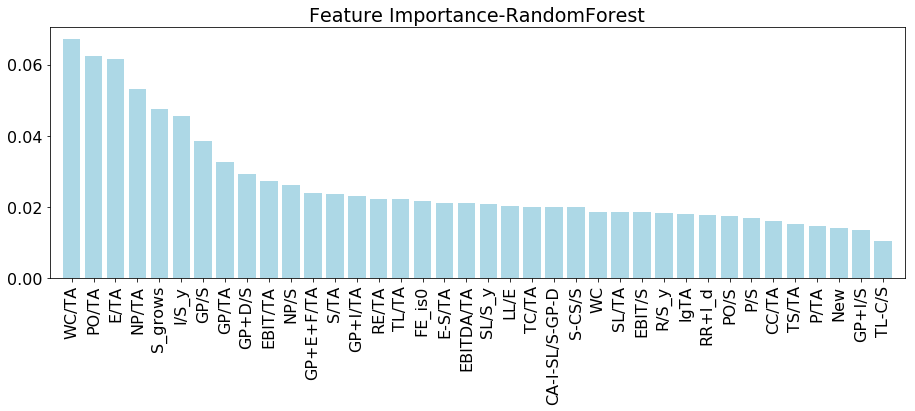

In [389]:
data = df.copy()
# drop '?' samples in lgTA
data.drop(list(data.loc[data.lgTA == '?'].index),inplace=True)
# New = 1 means new companies
data['New'] = 0
data.loc[data['S_grows']=='?','New'] = 1
data['S_grows'] = data['S_grows'].replace('?',1)
# FE_is0 = 1 means FE is 0
data['FE_is0'] = 0
data.loc[data['PO/FE']=='?','FE_is0'] = 1

# drop features, which have '?'
tem = pd.DataFrame((data == '?').sum().sort_values(ascending=False),columns=['not a ?'])
data = data.loc[:,list(tem.loc[tem['not a ?'] == 0].index)]
data = data.replace('?',np.nan)
data = pd.DataFrame(data,dtype=np.float)

Run_Pick(data, 1, 1)

### Comment
- Now we have about 30+ features, and ROC improves a lot.
- Problems is that many features seem not that important.
- Next Setp: deal with other missing value, my idea is that

In [384]:
data = data.replace('?',np.nan)
data.dropna()
data = pd.DataFrame(data,dtype=np.float)
pd.set_option('display.max_columns', None)
data.describe()

,Id,NP/TA,TL/TA,WC/TA,CA/SL,C+SS+R-SL/OE-D_y,RE/TA,EBIT/TA,BVE/TL,S/TA,E/TA,GP+E+F/TA,GP/SL,GP+D/S,GP+I/TA,TL/GP+D_y,GP+D/TL,TA/TL,GP/TA,GP/S,I/S_y,S_grows,PO/TA,NP/S,GP3/TA,E-S/TA,NP+D/TL,PO/FE,WC/FA,lgTA,TL-C/S,GP+I/S,CL/CS_y,OE/SL,OE/TL,P/TA,TS/TA,CA-I/LL,CC/TA,P/S,CA-I-R/SL,TL/PO+D_d_m,PO/S,RR+I_d,R/S_y,NP/I,CA-I/SL,I/CS_y,EBITDA/TA,EBIT/S,CA/TL,SL/TA,SL/CP_y,E/FA,CC/FA,WC,S-CS/S,CA-I-SL/S-GP-D,TC/TA,LL/E,S/I,S/R,SL/S_y,S/SL,S/FA,Bankrupt
count,3107.000000,3104.000000,3104.000000,3104.000000,3093.000000,3.102000e+03,3104.000000,3104.000000,3094.000000,3106.000000,3104.000000,3104.000000,3093.000000,3107.000000,3104.000000,3.102000e+03,3094.000000,3094.000000,3104.000000,3107.000000,3107.000000,3006.000000,3104.000000,3107.000000,3046.000000,3104.000000,3094.000000,2854.000000,3051.000000,3104.000000,3107.000000,3107.000000,3.087000e+03,3093.000000,3094.000000,3104.000000,3104.000000,1757.000000,3104.000000,3107.000000,3093.000000,3065.000000,3107.000000,3107.000000,3107.000000,2951.000000,3093.000000,3091.000000,3104.000000,3107.000000,3094.000000,3104.000000,3091.000000,3051.000000,3051.000000,3.107000e+03,3107.000000,3105.000000,3107.000000,3105.000000,2951.000000,3098.000000,3107.000000,3093.000000,3051.000000,3107.000000
mean,3116.645961,-0.129964,0.587445,0.155260,4.062002,-3.568491e+02,-0.192565,-0.117546,5.533726,1.609310,0.485187,-0.098294,0.698932,-0.135274,-0.117546,-8.275715e+02,0.653186,6.626995,-0.117546,-0.186074,57.277489,1.092394,-0.080764,-0.192498,0.034907,0.332775,0.587123,579.707773,11.205773,4.129581,1.224169,-0.147815,3.825191e+03,7.560980,4.071160,-0.085935,2.242026,94.226200,0.572861,-0.007868,1.715561,2.360590,-0.061251,173.679019,116.401467,1.296237,3.152579,140.904988,-0.183641,-0.112167,3.188604,0.462479,0.831512,13.704243,14.203648,1.078597e+04,0.035035,-0.451769,0.978707,0.172059,47.197421,10.884574,361.366703,8.203592,92.081806,0.131960
std,1780.610118,8.354761,1.685164,1.582721,25.146686,1.938420e+04,9.571363,8.355412,67.285082,1.496047,5.086219,8.355027,19.774578,7.327641,8.355412,1.755961e+05,6.574166,67.294103,8.355412,7.350188,192.982914,3.174944,7.760878,7.314915,9.867053,5.195663,6.468218,12453.065655,395.246815,0.846147,25.851850,7.089086,1.167871e+05,35.887015,22.245251,7.758748,17.549577,1659.923086,5.080282,0.962377,17.773965,92.702782,2.912918,1038.386060,962.816250,45.591538,24.083967,3435.477080,9.754474,2.963503,21.739550,1.456876,12.966981,422.284429,422.209645,6.348214e+04,0.936503,23.903177,1.080713,5.038965,425.444250,38.230778,8571.476168,35.719389,2925.813103,0.338502
min,0.000000,-463.890000,0.000000,-72.067000,-0.403110,-1.076400e+06,-463.890000,-463.890000,-0.986570,-3.496000,-71.444000,-463.890000,-231.850000,-310.340000,-463.890000,-9.632400e+06,-221.330000,0.000000,-463.890000,-310.800000,-29.340000,-135.150000,-431.590000,-310.890000,-463.890000,-71.444000,-221.330000,-85788.000000,-1089.700000,0.667830,-16.110000,-310.800000,-2.551000e+02,-1.433400,-16.015000,-431.590000,0.000191,-4.325800,-71.444000,-47.047000,-0.342860,-269.990000,-143.520000,-3975.600000,-3946.200000,-1318.100000,-0.342860,-18.658000,-542.560000,-144.800000,0.000000,-0.186610,-0.697640,-1088.700000,-1088.700000,-2.955400e+05,-46.788000,-1236.300000,-0.164390,-184.980000,-12.440000,-0.092493,-236.530000,-1.543200,-3.726500,0.000000
25%,1552.500000,0.001105,0.259027,0.028555,1.059000,-4.930225e+01,0.000000,0.002731,0.448335,1.012000,0.298940,0.009534,0.005776,0.019621,0.002731,1.907000e+02,0.058444,1.474425,0.002731,0.001816,18.246500,0.978110,0.000000,0.000663,0.007272,0.153323,0.054376,0.022249,0.052818,3.633950,0.091894,0.003906,5.073100e+01,2.699100,0.259087,0.003948,1.066075,1.272100,0.414100,0.002744,0.045408,0.025863,0.000000,76.301000,38.250500,0.005881,0.608500,19.140500,-0.037050,-0.029594,0.799192,0.183555,0.138580,0.717670,0.964220,2.954450e+01,0.007456,0.013129,0.878775,0.000000,5.205650,4.275775,46.156500,2.957100,2.146600,0.000000
50%,3111.000000,0.043487,0.466435,0.205430,1.607200

### Comment:
1. From the above form, we can see the max and min value is very large or very small, and it often happen when financial indicator devided by sales, liability and inventory. The reason is that the sales can be very small, like 1, and then this feature devided 1 will be very large.
2. Many companies don't have loan, so there are many missing in these part. My idea is just deleteing this feature, whcih divided by short or long term liability, because we can just use 'Liability/ Total Asset' to precent the leverage, and we dont need every indicator devided by liability.
3. We can calculate some indicator by others and use that to replace the features which have many missing.
> for example, 'Sale/Fixed Asset' have many missing because some FA is 0. But we know 'S/TA' and lgTA. So use lgTA to get Total Asset and than get Sale, next we can calculate FA. Finally, use FA/TA to represent this information and delete 'S/FA' feature. I use that we to get many new features.


train data has 2172 sample, test data has 932 sample
Naive Byes: CV score = 0.88, in sample Accuracy = 89.09%, out of sample Accuracy = 90.67%
Logistic: CV score = 0.89, in sample Accuracy = 90.93%, out of sample Accuracy = 91.09%, roc = 84.15%


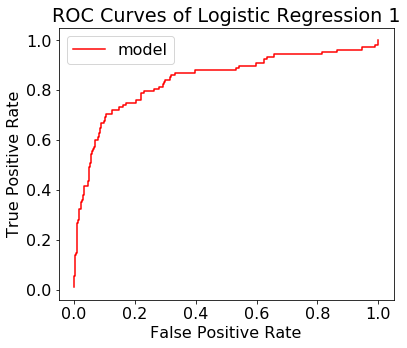

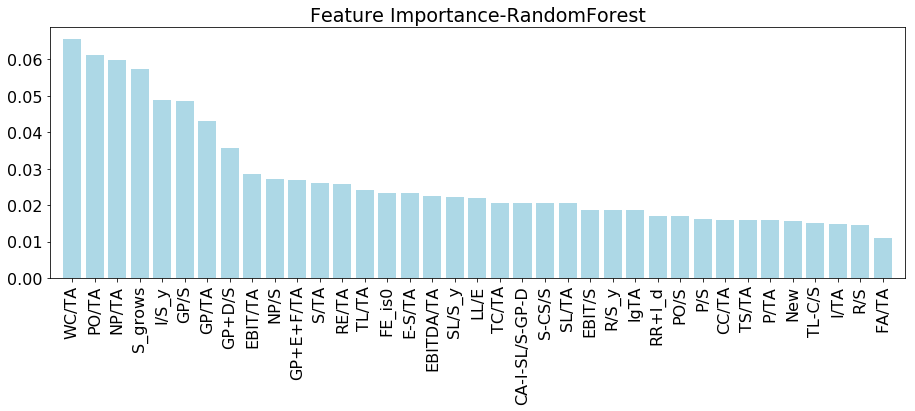

In [390]:
data = df.copy()
data.drop(list(data.loc[data.lgTA == '?'].index),inplace=True)
# New and FE_is0 are just as above
data['New'] = 0
data.loc[data['S_grows']=='?','New'] = 1
data['S_grows'] = data['S_grows'].replace('?',1)
data['FE_is0'] = 0
data.loc[data['PO/FE']=='?','FE_is0'] = 1

tem = pd.DataFrame((data == '?').sum().sort_values(ascending=False),columns=['not a ?'])
data = data.loc[:,list(tem.loc[tem['not a ?'] == 0].index)+['S/FA','S/R']]

data = data.replace('?',np.nan)
data = pd.DataFrame(data,dtype=np.float)
# get Total Asset, get Sales and Gross Profit
data['TA'] = np.power(10, data['lgTA'])
data['S'] = data['S/TA'] * data['TA']
data['GP'] = data['GP/S'] * data['S']
# then we can get Inventory
data['I/TA'] = (data['GP+I/S'] * data['S'] - data['GP']) / data['TA']
# retained earnings / Sales
data['R/S'] = (1 / data['S/R']).fillna(0)
# Fixed Asset
data['FA/TA'] = (data['S'] / data['S/FA']).fillna(0) / data['TA']

del data['S/FA'], data['S/R'],data['S'],data['TA'],data['GP+I/TA'],data['GP+I/S'],data['WC'],data['E/TA'], data['GP']

Run_Pick(data, 1 ,1)

### Comment
1. The feature engineering works, more features add in with out sacrificing the samples.
2. Problems is that many feature is not so important.


## Deal with Unblanced data
1. Problem: 
2. Solution: give different importance of each type of misclassification
混淆矩阵

train data has 2172 sample, test data has 932 sample
Naive Byes: CV score = 0.88, in sample Accuracy = 89.09%, out of sample Accuracy = 90.67%
Logistic: CV score = 0.88, in sample Accuracy = 88.86%, out of sample Accuracy = 87.77%, roc = 86.61%


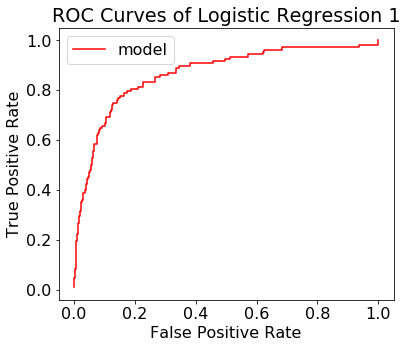

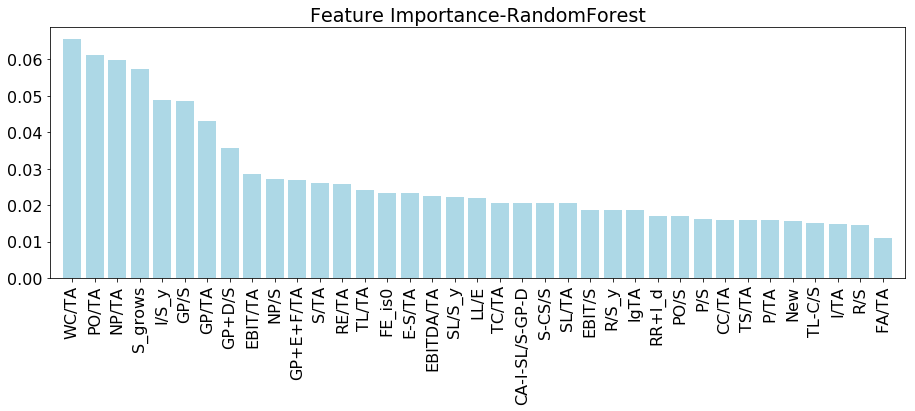

In [395]:
Run_Pick(data, 0.2, 1)

In [173]:
data = df.copy()
data.drop(list(data.loc[data.lgTA == '?'].index),inplace=True)

data = data.replace('?',np.nan)
data = pd.DataFrame(data,dtype=np.float)
data = shuffle(data, random_state=0).copy()


data['TA'] = np.power(10, data['lgTA'])
data['S'] = data['S/TA'] * data['TA']
data['GP'] = data['GP/S'] * data['S']
data['I'] = data['GP+I/S'] * data['S'] - data['GP']
data['R/S'] = (1 / data['S/R']).fillna(0)
data['FA'] = (data['S'] / data['S/FA']).fillna(0)

In [207]:
data.loc[data['E/TA']==0]

,WC/TA,PO/TA,E/TA,NP/TA,S_grows,I/S_y,GP/S,GP/TA,GP+D/S,EBIT/TA,NP/S,GP+E+F/TA,S/TA,RE/TA,TL/TA,FE_is0,E-S/TA,EBITDA/TA,Bankrupt,SL/S_y,LL/E,TC/TA,CA-I-SL/S-GP-D,S-CS/S,SL/TA,EBIT/S,R/S_y,lgTA,RR+I_d,PO/S,P/S,CC/TA,TS/TA,P/TA,New,TL-C/S,Id,GP,I/TA,R/S,FA/TA


In [196]:

data['New'] = 0
data.loc[data['S_grows']=='?','New'] = 1
data['S_grows'] = data['S_grows'].replace('?',1)

print(len(data.loc[(data['CA-I/LL']=='?') & (data['LL/E']=='0')]) / len(data.loc[(data['CA-I/LL']=='?')]))

data = data.drop(['CA-I/LL'], axis = 1)
len(data)

0.9985185185185185


3107

In [176]:
tem = data.loc[:,['NP/I', 'S/I']].replace('?',np.nan)
tem = pd.DataFrame(tem,dtype=np.float)
(tem == 0).sum().sort_values(ascending=False)

NP/I    20
S/I      0
dtype: int64

In [193]:
data = data.drop([ 'CA-I/LL', 'CA-I/SL', 'CA-I-R/SL', 'S/SL', 'CA/SL', 'GP+D/TL',\
                  'CA/TL','TA/TL', 'BVE/TL', 'NP+D/TL', 'OE/TL'], axis = 1)

train data has 1784 sample, test data has 765 sample
Naive Byes: Avg cross val score = 0.34, in sample Accuracy = 20.80%, out of sample Accuracy = 19.48%
RF: Avg cross val score = 0.93, in sample Accuracy = 99.94%, out of sample Accuracy = 94.38%
Logistic Regression: Avg cross val score = 0.90, in sample Accuracy = 89.52%, out of sample Accuracy = 91.76%, roc = 74.44%


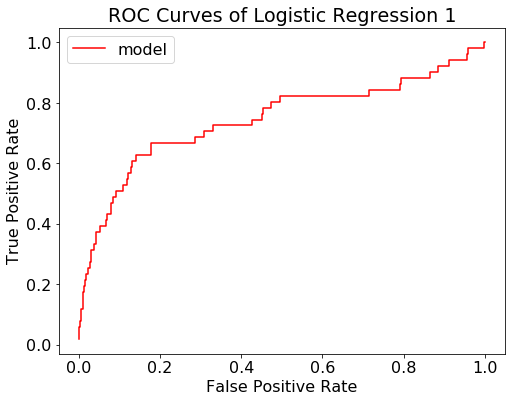

In [197]:
t(data)

In [162]:
pd.set_option('display.max_columns', None)
data.describe()

,Id,NP/TA,TL/TA,WC/TA,CA/SL,C+SS+R-SL/OE-D_y,RE/TA,EBIT,BVE/TL,S/TA,E/TA,GP+E+F/TA,GP/SL,GP+D/S,GP+I/TA,TL/GP+D_y,GP+D/TL,TA/TL,GP/TA,GP/S,I/S_y,S_grows,PO/TA,NP/S,GP3/TA,E-S/TA,NP+D/TL,PO/FE,WC/FA,TA,TL-C/S,GP+I/S,CL/CS_y,OE/SL,OE/TL,P/TA,TS/TA,CA-I/LL,CC/TA,P/S,CA-I-R/SL,TL/PO+D_d_m,PO/S,RR+I_d,R/S_y,NP/I,CA-I/SL,I/CS_y,EBITDA/TA,EBIT/S,CA/TL,SL/TA,SL/CP_y,E/FA,CC/FA,WC,S-CS/S,CA-I-SL/S-GP-D,TC/TA,LL/E,S/I,S/R,SL/S_y,S/SL,S/FA,Bankrupt,New
count,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1.564000e+03,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000
mean,3044.074169,0.039885,0.549945,0.150259,2.196486,16.423290,-0.082579,0.049267,1.511598,1.365576,0.426570,0.067597,0.275345,0.063556,0.049267,1764.333256,0.346237,2.594418,0.049267,0.016931,54.425253,1.174278,0.067396,0.010368,0.083624,0.329022,0.315649,27.442306,1.210921,4.413738,0.472703,0.025695,211.698882,5.074898,1.761651,0.069062,1.628261,102.602674,0.569184,0.038779,0.522800,3.675815,0.035459,129.447074,75.021789,0.837183,1.463769,178.727771,0.009477,-0.011175,1.361411,0.384117,0.574069,1.150009,1.997020,1.151732e+04,0.063521,0.116493,0.940436,0.283458,28.439045,8.197535,112.827811,5.488675,11.166129,0.081841,0.017263
std,1702.128014,0.128775,0.307974,0.267023,8.285541,1211.323741,3.095396,0.136557,2.234637,0.776503,0.303958,0.128993,0.854136,0.278247,0.136557,13689.396000,0.662829,2.380406,0.136557,0.296262,60.647963,1.074321,0.120284,0.293424,3.092570,0.378977,0.619461,964.531227,8.562239,0.703543,1.659629,0.289538,3503.328760,5.329353,2.199627,0.129789,0.930233,1758.963183,0.252320,0.179965,3.905854,128.809168,0.284332,220.332369,178.700516,19.351209,6.178224,4692.362640,0.219075,0.319549,1.532595,0.246716,9.596951,11.333595,7.394820,5.614474e+04,0.200100,2.808997,0.178074,7.001870,225.945753,10.769007,231.231952,5.600809,129.759199,0.274211,0.130293
min,0.000000,-1.373200,0.029261,-3.299100,0.020205,-11127.000000,-100.380000,-1.373200,-0.751680,0.011616,-3.027200,-1.098300,-9.828600,-7.826000,-1.373200,-271440.000000,-2.382500,0.248310,-1.373200,-8.816600,0.049383,0.000000,-1.098300,-8.816600,-121.520000,-3.318300,-2.400300,-22025.000000,-10.058000,1.646500,-1.239000,-8.816200,3.208500,0.002636,-1.120000,-1.102900,0.013176,-0.542280,-2.366300,-3.339900,-0.335160,-269.990000,-8.856300,11.715000,1.171900,-253.770000,-0.148860,0.000760,-5.431900,-9.846900,0.011558,0.003121,0.008790,-414.740000,-9.057800,-2.955400e+05,-3.339900,-38.520000,-0.164390,-184.980000,0.222090,0.056660,3.111800,0.043904,0.013466,0.000000,0.000000
25%,1517.500000,0.003455,0.354310,0.018757,1.048375,-54.267000,0.000000,0.004911,0.415210,1.009450,0.283863,0.013448,0.012315,0.026391,0.004911,451.505000,0.072069,1.450000,0.004911,0.003601,23.251000,1.001650,0.011638,0.002495,0.020511,0.167075,0.069606,0.114140,0.035118,3.980200,0.176592,0.006224,60.720750,2.664250,0.178807,0.014223,1.019975,1.294300,0.446218,0.008946,0.039864,0.050917,0.007162,81.933750,39.937250,0.015033,0.593820,24.242250,-0.031907,-0.024128,0.706492,0.218707,0.164958,0.614540,0.933362,2.709925e+00,0.013448,0.012419,0.892207,0.033440,5.249750,4.391300,55.469750,2.928225,1.874350,0.000000,0.000000
50%,3073.500000,0.039788,0.518610,0.154680,1.452800,-12.951500,0.000000,0.046866,0.864225,1.092050,0.454085,0.064500,0.131775,0.066518,0.046866,1258.90

In [182]:
#随机森林评估特征重要性
data = data.replace('?',np.nan)
data = data.dropna()
data = pd.DataFrame(data,dtype=np.float)
data = shuffle(data, random_state=0).copy()
x, y = data.iloc[:,:].copy(), data['Bankrupt']
del x['Bankrupt'], x['Id']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
feat_labels=x_train.columns[:]
forest=RandomForestClassifier(n_estimators=1000,n_jobs=-1,random_state=0,class_weight={1:5,0:1})
forest.fit(x_train,y_train)
importances=forest.feature_importances_
indices=np.argsort(importances)[::-1]
print(indices)

[37 26 34 20 33 63 40 21 39 28 24 25 12 53 44 22 15  8 14 18 23  0  5 54
 41 42 59  6 10 43 17 30 13 52 27 46 49 11 38 56 62 36 35  4 19 51  1  2
 47  3 58 61 31 29 16 48 57 60 45  7 55 50 32  9]


 1) NP/TA                          0.063425
 2) TL/TA                          0.057211
 3) WC/TA                          0.056717
 4) CA/SL                          0.041539
 5) C+SS+R-SL/OE-D_y               0.039402
 6) RE/TA                          0.038392
 7) EBIT                           0.034142
 8) BVE/TL                         0.032534
 9) S/TA                           0.030125
10) E/TA                           0.026675
11) GP+E+F/TA                      0.024949
12) GP/SL                          0.024523
13) GP+D/S                         0.022382
14) GP+I/TA                        0.020958
15) TL/GP+D_y                      0.020214
16) GP+D/TL                        0.018906
17) TA/TL                          0.016180
18) GP/TA                          0.016086
19) GP/S                           0.015548
20) I/S_y                          0.015335
21) S_grows                        0.014917
22) PO/TA                          0.013945
23) NP/S                        

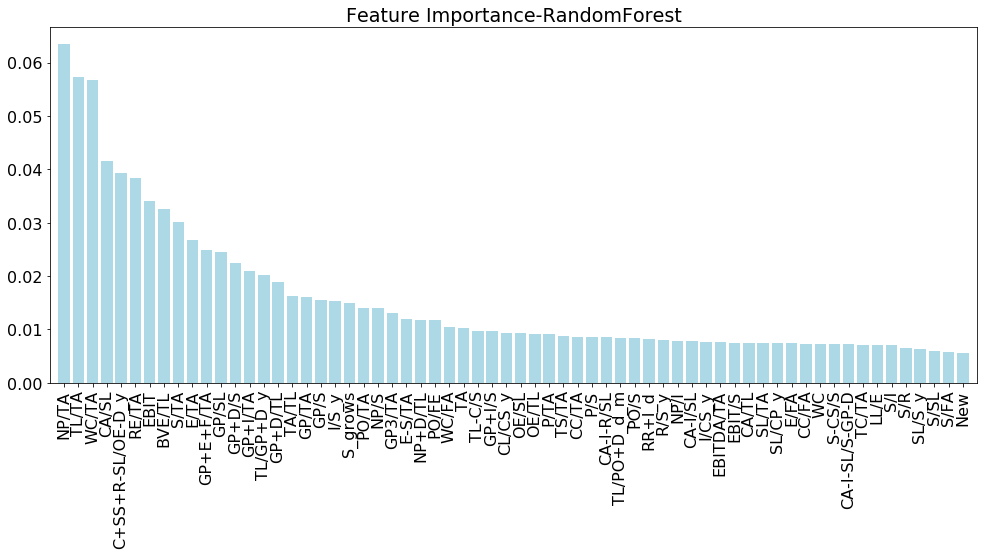

In [183]:
for f in range(x_train.shape[1]):
    #给予100颗决策树平均不纯度衰减的计算来评估特征重要性
    print ("%2d) %-*s %f" % (f+1,30,feat_labels[f],importances[indices[f]]) )
#可视化特征重要性-依据平均不纯度衰减
f, ax = plt.subplots(figsize=(14, 8))
plt.title('Feature Importance-RandomForest')
plt.bar(range(x_train.shape[1]),importances[indices],color='lightblue',align='center')
plt.xticks(range(x_train.shape[1]),feat_labels,rotation=90)
plt.xlim([-1,x_train.shape[1]])
plt.tight_layout()
plt.show()
 
#在这个基础上，随机森林海可以通过阈值压缩数据集
#X_selected=forest.(x_train,threshold=0.03)#大于0.15只有三个特征
#print(x_selected)

In [191]:
def t(df):
    df = df.replace('?',np.nan)
    df = df.dropna()
    df = pd.DataFrame(df,dtype=np.float)
    df = shuffle(df, random_state=0).copy()
    x, y = df.iloc[:,:].copy(), df['Bankrupt']
    del x['Bankrupt'], x['Id']
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
    print("train data has {a} sample, test data has {b} sample".format(a = len(x_train), b = len(x_test)))
    
    model = "Naive Byes"
    accuracy1, accuracy2, scores,y_pred1, y_pred2, y_score = Run_Model('NB', x_train, y_train, x_test, y_test)
    print("{m:s}: Avg cross val score = {sc:3.2f}, in sample Accuracy = {a1:.2%}, out of sample Accuracy = {a2:.2%}".format(\
            m=model, sc=scores.mean(), a1=accuracy1, a2=accuracy2))

    model = "RF"
    accuracy1, accuracy2, scores,y_pred1, y_pred2, y_score = Run_Model('RF', x_train, y_train, x_test, y_test)
    print("{m:s}: Avg cross val score = {sc:3.2f}, in sample Accuracy = {a1:.2%}, out of sample Accuracy = {a2:.2%}".format(\
            m=model, sc=scores.mean(), a1=accuracy1, a2=accuracy2))

    model = "Logistic Regression"
    accuracy1, accuracy2, scores,y_pred1, y_pred2, y_score = Run_Model('LR', x_train, y_train, x_test, y_test)
    model_fpr, model_tpr, _ = roc_curve(y_test,y_score)
    roc = roc_auc_score(y_test, y_score)
    print("{m:s}: Avg cross val score = {sc:3.2f}, in sample Accuracy = {a1:.2%}, out of sample Accuracy = {a2:.2%}, roc = {r:.2%}".format(\
                    m=model, sc=scores.mean(), a1=accuracy1, a2=accuracy2, r = roc))

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    # Plot both curves
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves of Logistic Regression 1')
    plt.show()

In [187]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca.fit(x_train)
print (pca.explained_variance_ratio_)

[0.65914866 0.29540447 0.04114565 0.00277658 0.00124964]


## Transformation


In [ ]:
zero_total = ((data == 0) ^ (data == '0')).sum().sort_values(ascending=False)
zero_percent = (((data == 0) ^ (data == '0')).sum()/data.count()).sort_values(ascending=False)
zero_data = pd.concat([zero_total, zero_percent], axis=1, keys=['0 Total', '0 Percent'], sort = False)
zero_data = zero_data.loc[zero_data['0 Total'] > 0]
print(zero_data.head(10))

for i in zero_data.index:
    print(i,': ', data.loc[(data[i] == 0)^(data[i] is '0')].Bankrupt.sum()/len(data.loc[(data[i] == 0)^(data[i] is '0')]))

In [ ]:
# missing value
#data['TA'] = data['TA'].replace('?',np.nan)  # only 4 sample

data['LL_is0'] = 0
data.loc[data['CA-I/LL'] == '?','LL_is0'] = 1
del data['CA-I/LL']

data['New'] = 0
data.loc[data['S_grows'] == '?','New'] = 1
data.loc[data['S_grows'] == '?','S_grows'] = 0

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve

# Calculate false positive rates and true positive rates
#base_fpr, base_tpr, _ = roc_curve(july_labels['label'], july_labels['probability'])

model_fpr, model_tpr, _ = roc_curve(y_test,y_score)

plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16
# Plot both curves
#plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
plt.plot(model_fpr, model_tpr, 'r', label = 'model')
plt.legend();
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

In [ ]:
from sklearn.metrics import confusion_matrix
C=confusion_matrix(y_test, y_pred2)
C

In [ ]:
缺失值处理：
？代表infinite，如果LL=0 可以直接作为属性，如果TA=0 删除这一行
2. 目标是predict bankrupt的概率
3. 有没有办法区分出行业 或者潜在的信息 比如高负债的银行业？
4. 高度相关的指标 删掉？
5. shuffle
6. 有些指标的经济意义是什么
7

In [ ]:
1. 主要分成几类：经营性指标 周转率 利润率；负债型指标 负债绿 长短期比例；增长型指标 sale增速
2. AUC + 两侧阈值解决不对称
3. missing value 分类讨论
4. 无LL这种可以单独生成变量。根据ta可以算出s，根据s可以算出sl和ll，可以算出sl/ta, ll/ta的指标
5. 高负债+无存货 视为金融业，单独特征

In [ ]:
pd.set_option('display.max_columns', None)
data.loc[data['TL/TA']>5]

In [ ]:
data = data.drop_duplicates()

In [ ]:
data.describe()

In [ ]:
# missing value
data['TA'] = data['TA'].replace('?',np.nan)  # only 4 sample
data = data.dropna()
data = data.replace('?',np.nan)
#print((data == 0).sum(axis=0))
#data = data.replace(0,np.nan)
data = pd.DataFrame(data,dtype=np.float)

total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

## Description of attributes

In [ ]:
from sklearn.metrics import confusion_matrix
C=confusion_matrix(y_test, y_pred2)
C

In [ ]:
data.Bankrupt.sum()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve

# Calculate false positive rates and true positive rates
#base_fpr, base_tpr, _ = roc_curve(july_labels['label'], july_labels['probability'])

model_fpr, model_tpr, _ = roc_curve(y_test,y_score)

plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16
# Plot both curves
#plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
plt.plot(model_fpr, model_tpr, 'r', label = 'model')
plt.legend();
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

In [ ]:
print((data == 0).sum(axis=0))

In [ ]:
#correlation matrix
corrmat = data.corr()
f, ax = plt.subplots(figsize=(30, 30))
sns.set(font_scale=0.85)
sns.heatmap(corrmat, annot = True, vmax=.8, square=True);

In [26]:
test = pd.read_csv( os.path.join(DATA_PATH, "test.csv") )
test = test.drop_duplicates()
test.columns = ['Id','NP/TA','TL/TA','WC/TA','CA/SL','C+SS+R-SL/OE-D_y','RE/TA','EBIT','BVE/TL','S/TA','E/TA',
    'GP+E+F/TA','GP/SL','GP+D/S','GP+I/TA','TL/GP+D_y','GP+D/TL','TA/TL','GP/TA','GP/S','I/S_y',
    'S_grows','PO/TA','NP/S','GP3/TA','E-S/TA','NP+D/TL','PO/FE','WC/FA','TA','TL-C/S',
    'GP+I/S','CL/CS_y','OE/SL','OE/TL','P/TA','TS/TA','CA-I/LL','CC/TA','P/S','CA-I-R/SL',
    'TL/PO+D_d_m','PO/S','RR+I_d','R/S_y','NP/I','CA-I/SL','I/CS_y','EBITDA/TA','EBIT/S','CA/TL',
    'SL/TA','SL/CP_y','E/FA','CC/FA','WC','S-CS/S','CA-I-SL/S-GP-D','TC/TA','LL/E','S/I',
    'S/R','SL/S_y','S/SL','S/FA']

test

,Id,NP/TA,TL/TA,WC/TA,CA/SL,C+SS+R-SL/OE-D_y,RE/TA,EBIT,BVE/TL,S/TA,E/TA,GP+E+F/TA,GP/SL,GP+D/S,GP+I/TA,TL/GP+D_y,GP+D/TL,TA/TL,GP/TA,GP/S,I/S_y,S_grows,PO/TA,NP/S,GP3/TA,E-S/TA,NP+D/TL,PO/FE,WC/FA,TA,TL-C/S,GP+I/S,CL/CS_y,OE/SL,OE/TL,P/TA,TS/TA,CA-I/LL,CC/TA,P/S,CA-I-R/SL,TL/PO+D_d_m,PO/S,RR+I_d,R/S_y,NP/I,CA-I/SL,I/CS_y,EBITDA/TA,EBIT/S,CA/TL,SL/TA,SL/CP_y,E/FA,CC/FA,WC,S-CS/S,CA-I-SL/S-GP-D,TC/TA,LL/E,S/I,S/R,SL/S_y,S/SL,S/FA
0,5560,-0.3811,0.98042,-0.6765,0.30999,-66.3030,0.040954,-0.3811,0.019559,3.718600,0.019176,-0.37131,-0.38871,-0.102490,-0.3811,-939.000,-0.38871,1.02,-0.3811,-0.102490,6.13110,0.70074,-0.35623,-0.102490,-0.3732,-0.066468,-0.38871,-14.319,-0.97147,3.0885,0.250680,-0.095795,117.94,4.1625,4.1625,-0.25102,3.7249,?,0.019176,-0.067504,0.062105,-0.09174,-0.095797,23.8550,17.7240,-6.1012,0.12582,5.5867,-0.35623,-0.095797,0.30999,0.98042,0.24024,0.027537,0.027537,-829.3900,0.184030,-19.874,0.84453,0,59.533,20.594,96.2340,3.7928,5.34
1,5547,-0.18257,0.8448,-0.28995,0.5086,-164.2900,-0.23909,-0.22144,0.18371,0.825390,0.1552,-0.18347,-0.37529,-0.184970,-0.22144,-2019.700,-0.18072,1.1837,-0.22144,-0.268290,71.72000,0.87335,-0.18355,-0.221200,0.97396,0.13941,-0.13471,-4.8334,-0.41428,3.9073,1.023500,-0.230400,209.93,1.7956,1.2541,-0.20051,0.82539,0.96703,0.29782,-0.242930,3.2E-05,-0.24534,-0.222380,132.7000,60.9820,-1.1257,0.23374,55.872,-0.25232,-0.305700,0.35524,0.59006,0.55692,0.22175,0.42552,-2342.1000,-0.242930,-1.1764,1.32970,0.91896,5.0893,5.9853,260.9300,1.3988,1.1793
2,3765,0.026793,0.66226,0.092265,1.1429,-104.6100,0,0.02929,0.50999,1.848500,0.33774,0.11067,0.045368,0.032319,0.02929,4046.200,0.090208,1.51,0.02929,0.015845,96.92900,1.5618,0.10646,0.014495,-0.010575,0.13665,0.086438,1.3081,0.35198,4.1591,0.349850,0.024092,133.71,2.7298,2.6611,0.086119,1.8485,?,0.33774,0.046589,0.1862,0.16124,0.057591,121.9600,25.0340,0.054583,0.38257,101.67,0.076005,0.041117,1.1142,0.6456,0.36633,1.2885,1.2885,1331.0000,0.046589,0.07933,0.98460,0,3.7657,14.58,127.4800,2.8632,7.0517
3,3260,0.016032,0.00791,0.050838,7.4273,138.3700,0.092864,0.019979,125.22,1.083500,0.99045,0.019979,2.5259,0.544960,0.019979,18.299,19.946,126.43,0.019979,0.069012,0.00000,1.0051,0.021378,0.055376,0.11481,0.99045,19.447,0.80005,0.054012,3.8403,-0.149870,0.069012,10.805,33.782,2.7027,0.021378,0.29047,?,0.99045,0.073842,6.6238,0.001634,0.073842,8.0128,8.0128,?,7.4273,0,-0.11641,-0.402100,7.4273,0.00791,0.029602,1.0523,1.0523,351.9600,0.077040,0.016186,0.92296,0,?,45.552,9.9723,36.601,0.30758
4,5550,-0.16316,0.32305,0.41093,2.8427,-17.0310,0,-0.16316,2.0947,0.737130,0.6767,-0.11833,-0.73167,-0.221350,-0.16316,-722.690,-0.50506,3.0955,-0.16316,-0.221350,175.23000,0.69285,-0.12922,-0.221350,-0.18525,0.48928,-0.50506,-3.7457,1.1233,3.6043,0.389690,-0.192890,162.18,5.1221,3.5357,-0.22683,1.0137,?,0.6767,-0.307720,0.65861,-0.083332,-0.175310,241.1700,65.9360,-0.46105,2.2456,113.09,-0.12922,-0.175310,1.9623,0.223,0.19523,1.8498,1.8498,1652.3000,0.319160,-0.24111,0.67127,0,2.0829,5.5356,110.4200,3.3056,2.015
5,1923,0.067091,0.23159,0.67084,3.8967,166.2600,0.20476,0.083085,2.7323,1.049700,0.63277,0.083085,0.35876,0.076309,0.083085,861.170,0.42384,4.318,0.083085,0.064592,20.63100,1.0944,0.056685,0.052158,0.24834,0.63277,0.35478,0.46257,6.8754,4.551,-0.127780,0.064592,68.979,5.2915,0.24477,0.056685,1.3232,?,0.63277,0.044068,1.8788,0.10611,0.044068,132.6100,111.9800,0.92278,3.5828,21.656,0.041614,0.032351,3.8967,0.23159,0.18898,6.4852,6.4852,23856.0000,0.047321,0.10603,0.95268,0,17.692,3.2596,65.7150,5.5543,13.183
6,553,0.3961,0.19446,0.40711,3.293,84.1270,0,0.3961,4.1425,1.856000,0.80554,0.39619,2.231,0.259910,0.3961,147.130,2.4807,5.1425,0.3961,0.213420,14.61200,1.0779,0.36816,0.213420,0.94727,0.3961,2.4807,3839.9,0.98017,4.0252,-0.010413,0.213470,43.13,8.4627,7.7268,0.35346,1.856,?,0.80554,0.190440,1.2146,0.014263,0.198360,72.5710,57.9590,5.3311,2.8745,18.049,0.28186,0.151870,3.0066,0.17754,0.11816,1.9395,1.9395,4314.2000,0.190440,0.49171,0.79163,0,24.98,6.

# Extra credit opportunities
- Address the issue of: classes being imbalanced
- Address the issue of: Different importance of each type of misclassification
    - It is 5 times worse to misclassify a company that *does go bankrupt* than to misclassify a company that does not go bankrupt
        - Suppose we invest in a company for which we predict it will not go bankrupt
            - We incur substantial losses for a bad investment
        - The loss from not investing in a company that we incorrectly classify as going bankrupt is small (opportunity cost)